# Train, test, export model for Electricty monitor IDS 

Datasets is from personal usage documentation
<br> <br>
Clustered with unsupervised algorithm - Isolation Foreset
<br>
Feature classifying/learning with supervised algorithm - Random Forest

## Config

### Import

In [176]:
# Import necessary libraries
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt
import datetime
import joblib

from tabulate import tabulate
import mysql.connector
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, recall_score, roc_auc_score, make_scorer, accuracy_score, precision_score, f1_score
from sklearn.utils import resample  
from sklearn.ensemble import IsolationForest, RandomForestClassifier
from sklearn.neighbors import LocalOutlierFactor
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.svm import OneClassSVM
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import seaborn as sns

### database config

In [145]:
# Configure database connection
db_config = {
    'host': 'localhost',
    'user': 'root',
    'password': '',
    'database': 'db_esp32'
}

In [146]:
# Fetch data from the database with only power > 0 and order by created_at in descending order
def fetch_data():
    conn = mysql.connector.connect(**db_config)
    query = f"SELECT * FROM electricity_monitor WHERE power > 0.5 ORDER BY created_at DESC"
    df = pd.read_sql(query, conn)
    conn.close()
    return df

def get_deviceId():
    conn = mysql.connector.connect(**db_config)
    query = f"SELECT DISTINCT device_id FROM electricity_monitor"
    device_ids = pd.read_sql(query, conn)
    return device_ids

df = fetch_data()
device_ids = get_deviceId()

print(df.count())

C:\Users\Sabian\AppData\Local\Temp\ipykernel_29872\1538424201.py:5: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)
C:\Users\Sabian\AppData\Local\Temp\ipykernel_29872\1538424201.py:12: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  device_ids = pd.read_sql(query, conn)


data_id         31186
device_id       31186
voltage         31186
current         31186
power           31186
energy          31186
frequency       31186
power_factor    31186
created_at      31186
dtype: int64


## Pre-processing

### Load the datasets

In [147]:
print('Count: \n', df.count())
print('\ndatasets: \n', df.head())
print('\n')
print('device_ids: \n', device_ids)

Count: 
 data_id         31186
device_id       31186
voltage         31186
current         31186
power           31186
energy          31186
frequency       31186
power_factor    31186
created_at      31186
dtype: int64

datasets: 
    data_id          device_id  voltage  current  power  energy  frequency  \
0   193867  D4:8A:FC:60:47:60    198.4      0.0    0.9   1.258       49.9   
1   193866  D4:8A:FC:60:47:60    199.0      0.0    0.8   1.258       50.0   
2   193865  D4:8A:FC:60:47:60    200.3      0.0    1.0   1.258       49.9   
3   193864  D4:8A:FC:60:47:60    197.1      0.0    0.8   1.258       49.9   
4   193863  D4:8A:FC:60:47:60    194.9      0.0    0.9   1.258       49.9   

   power_factor          created_at  
0           1.0 2024-07-24 14:20:48  
1           1.0 2024-07-24 14:20:43  
2           1.0 2024-07-24 14:20:38  
3           1.0 2024-07-24 14:20:33  
4           1.0 2024-07-24 14:20:28  


device_ids: 
            device_id
0  D4:8A:FC:60:47:60


### Convert datetime into numeric

In [148]:
# df['created_at'] = df['created_at'].astype('int64') // 10**9


#### Handling missing values

In [149]:
print("before:\n\n", df.isnull().sum())
# Fill missing values with median
df['voltage'].fillna(df['voltage'].median())

# Fill device_id with the latest id
latest_id = device_ids['device_id'].iloc[-1]
df['device_id'].fillna(latest_id)

# Fill created_at with current date and time
df['created_at'].fillna(pd.to_datetime('now'))

print("\n\nafter:\n", df.isnull().sum())

before:

 data_id         0
device_id       0
voltage         0
current         0
power           0
energy          0
frequency       0
power_factor    0
created_at      0
dtype: int64


after:
 data_id         0
device_id       0
voltage         0
current         0
power           0
energy          0
frequency       0
power_factor    0
created_at      0
dtype: int64


## Model Training

### Split dataset for training and testing

In [150]:
train_df, test_df = train_test_split(df, test_size=0.33, random_state=42)

print(train_df.count())

data_id         20894
device_id       20894
voltage         20894
current         20894
power           20894
energy          20894
frequency       20894
power_factor    20894
created_at      20894
dtype: int64


In [151]:
# Inspect the distribution of the power feature
print("Power Distribution in Training Data:")
print(train_df['power'].describe())

Power Distribution in Training Data:
count    20894.000000
mean        15.464990
std         17.399168
min          0.600000
25%          6.900000
50%         16.300000
75%         17.400000
max       1000.100000
Name: power, dtype: float64


### Unsupervised Learning - Isolation Forest

### Train and predict 

Training Isolation Forest Model for Device ID: D4:8A:FC:60:47:60 with Contamination: 0.0631


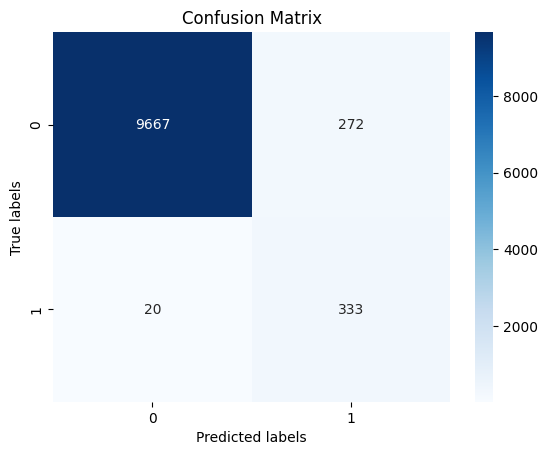

╒══════════╤════════════╤══════════════════════╤═══════════════════════╤════════════╤═════════════╤══════════╕
│ Metric   │   Accuracy │   True Negative Rate │   False Negative Rate │   F1 Score │   Precision │   Recall │
╞══════════╪════════════╪══════════════════════╪═══════════════════════╪════════════╪═════════════╪══════════╡
│ Value    │   0.971628 │             0.972633 │             0.0566572 │   0.695198 │    0.550413 │ 0.943343 │
╘══════════╧════════════╧══════════════════════╧═══════════════════════╧════════════╧═════════════╧══════════╛


Training Isolation Forest Model for Device ID: D4:8A:FC:60:47:60 with Contamination: 0.0632


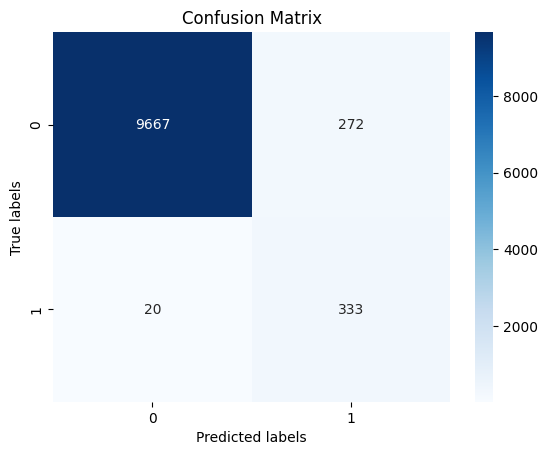

╒══════════╤════════════╤══════════════════════╤═══════════════════════╤════════════╤═════════════╤══════════╕
│ Metric   │   Accuracy │   True Negative Rate │   False Negative Rate │   F1 Score │   Precision │   Recall │
╞══════════╪════════════╪══════════════════════╪═══════════════════════╪════════════╪═════════════╪══════════╡
│ Value    │   0.971628 │             0.972633 │             0.0566572 │   0.695198 │    0.550413 │ 0.943343 │
╘══════════╧════════════╧══════════════════════╧═══════════════════════╧════════════╧═════════════╧══════════╛


Training Isolation Forest Model for Device ID: D4:8A:FC:60:47:60 with Contamination: 0.06330000000000001


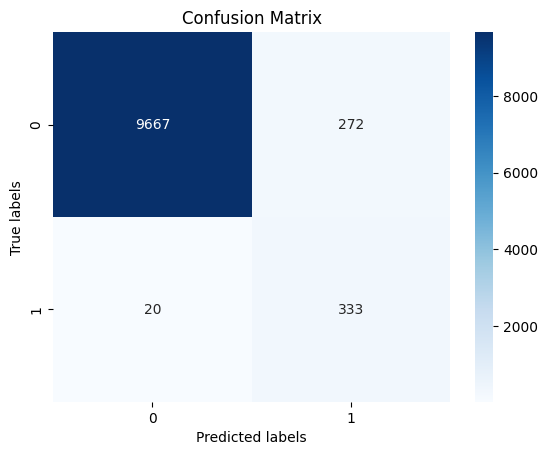

╒══════════╤════════════╤══════════════════════╤═══════════════════════╤════════════╤═════════════╤══════════╕
│ Metric   │   Accuracy │   True Negative Rate │   False Negative Rate │   F1 Score │   Precision │   Recall │
╞══════════╪════════════╪══════════════════════╪═══════════════════════╪════════════╪═════════════╪══════════╡
│ Value    │   0.971628 │             0.972633 │             0.0566572 │   0.695198 │    0.550413 │ 0.943343 │
╘══════════╧════════════╧══════════════════════╧═══════════════════════╧════════════╧═════════════╧══════════╛


Training Isolation Forest Model for Device ID: D4:8A:FC:60:47:60 with Contamination: 0.06340000000000001


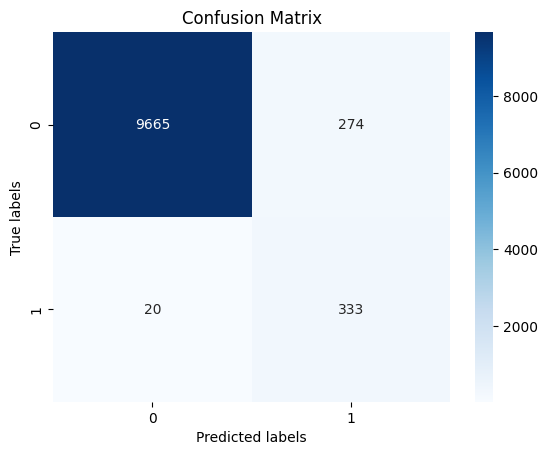

╒══════════╤════════════╤══════════════════════╤═══════════════════════╤════════════╤═════════════╤══════════╕
│ Metric   │   Accuracy │   True Negative Rate │   False Negative Rate │   F1 Score │   Precision │   Recall │
╞══════════╪════════════╪══════════════════════╪═══════════════════════╪════════════╪═════════════╪══════════╡
│ Value    │   0.971434 │             0.972432 │             0.0566572 │    0.69375 │      0.5486 │ 0.943343 │
╘══════════╧════════════╧══════════════════════╧═══════════════════════╧════════════╧═════════════╧══════════╛


Training Isolation Forest Model for Device ID: D4:8A:FC:60:47:60 with Contamination: 0.06350000000000001


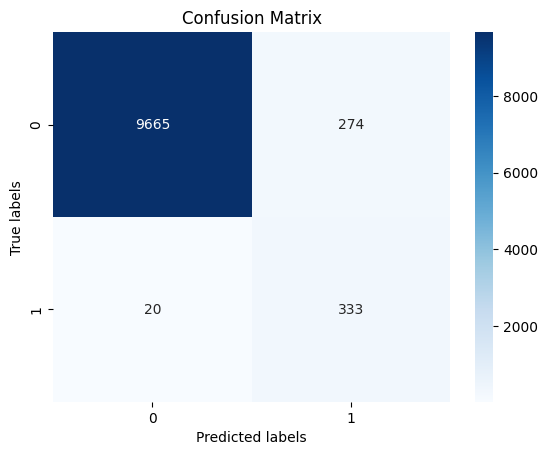

╒══════════╤════════════╤══════════════════════╤═══════════════════════╤════════════╤═════════════╤══════════╕
│ Metric   │   Accuracy │   True Negative Rate │   False Negative Rate │   F1 Score │   Precision │   Recall │
╞══════════╪════════════╪══════════════════════╪═══════════════════════╪════════════╪═════════════╪══════════╡
│ Value    │   0.971434 │             0.972432 │             0.0566572 │    0.69375 │      0.5486 │ 0.943343 │
╘══════════╧════════════╧══════════════════════╧═══════════════════════╧════════════╧═════════════╧══════════╛


Training Isolation Forest Model for Device ID: D4:8A:FC:60:47:60 with Contamination: 0.06360000000000002


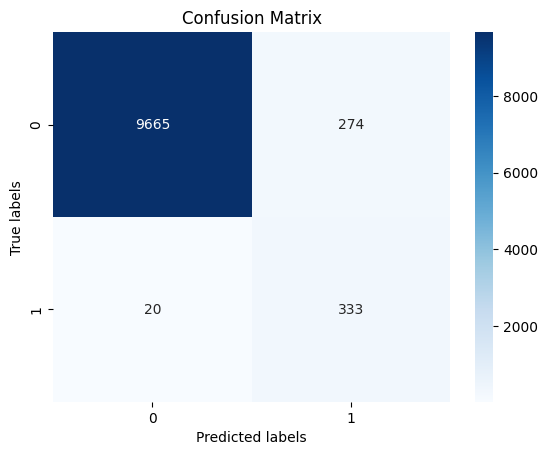

╒══════════╤════════════╤══════════════════════╤═══════════════════════╤════════════╤═════════════╤══════════╕
│ Metric   │   Accuracy │   True Negative Rate │   False Negative Rate │   F1 Score │   Precision │   Recall │
╞══════════╪════════════╪══════════════════════╪═══════════════════════╪════════════╪═════════════╪══════════╡
│ Value    │   0.971434 │             0.972432 │             0.0566572 │    0.69375 │      0.5486 │ 0.943343 │
╘══════════╧════════════╧══════════════════════╧═══════════════════════╧════════════╧═════════════╧══════════╛


Training Isolation Forest Model for Device ID: D4:8A:FC:60:47:60 with Contamination: 0.06370000000000002


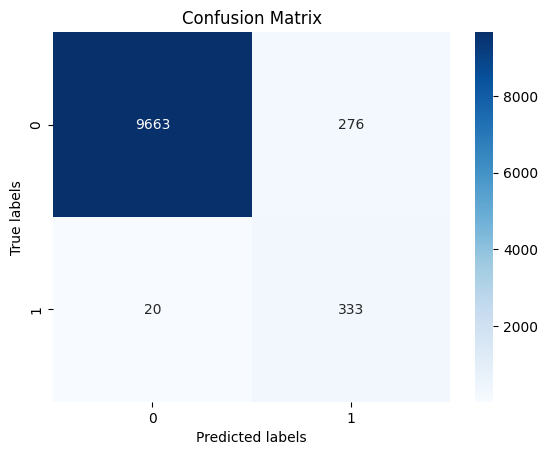

╒══════════╤════════════╤══════════════════════╤═══════════════════════╤════════════╤═════════════╤══════════╕
│ Metric   │   Accuracy │   True Negative Rate │   False Negative Rate │   F1 Score │   Precision │   Recall │
╞══════════╪════════════╪══════════════════════╪═══════════════════════╪════════════╪═════════════╪══════════╡
│ Value    │    0.97124 │             0.972231 │             0.0566572 │   0.692308 │    0.546798 │ 0.943343 │
╘══════════╧════════════╧══════════════════════╧═══════════════════════╧════════════╧═════════════╧══════════╛


Training Isolation Forest Model for Device ID: D4:8A:FC:60:47:60 with Contamination: 0.06380000000000002


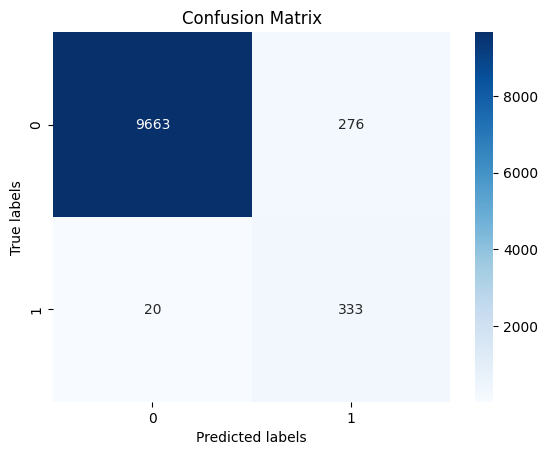

╒══════════╤════════════╤══════════════════════╤═══════════════════════╤════════════╤═════════════╤══════════╕
│ Metric   │   Accuracy │   True Negative Rate │   False Negative Rate │   F1 Score │   Precision │   Recall │
╞══════════╪════════════╪══════════════════════╪═══════════════════════╪════════════╪═════════════╪══════════╡
│ Value    │    0.97124 │             0.972231 │             0.0566572 │   0.692308 │    0.546798 │ 0.943343 │
╘══════════╧════════════╧══════════════════════╧═══════════════════════╧════════════╧═════════════╧══════════╛


Training Isolation Forest Model for Device ID: D4:8A:FC:60:47:60 with Contamination: 0.06390000000000003


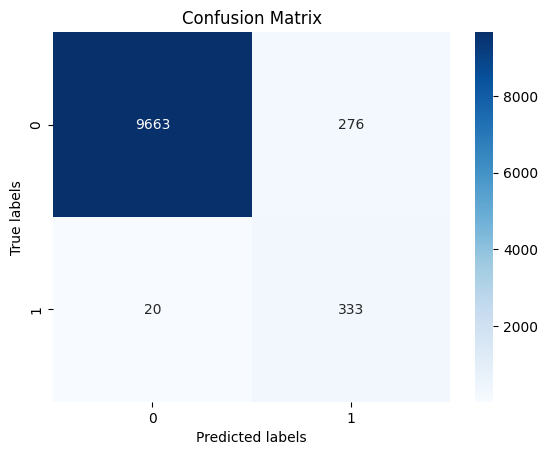

╒══════════╤════════════╤══════════════════════╤═══════════════════════╤════════════╤═════════════╤══════════╕
│ Metric   │   Accuracy │   True Negative Rate │   False Negative Rate │   F1 Score │   Precision │   Recall │
╞══════════╪════════════╪══════════════════════╪═══════════════════════╪════════════╪═════════════╪══════════╡
│ Value    │    0.97124 │             0.972231 │             0.0566572 │   0.692308 │    0.546798 │ 0.943343 │
╘══════════╧════════════╧══════════════════════╧═══════════════════════╧════════════╧═════════════╧══════════╛




In [188]:
def train_if():
    results = []
    for device_id in device_ids['device_id']:
        features = ['voltage', 'current', 'power', 'energy', 'frequency', 'power_factor']
        
        # Filter data for the specific device
        device_data = df[df['device_id'] == device_id]
        
        # Create labels based on the power threshold
        device_data['label'] = np.where(device_data['power'] > 50, 1, 0)
        
        # Split the data
        train_df, test_df = train_test_split(device_data, test_size=0.33, random_state=42)
        
        for ctm in np.arange(0.0631, 0.0640, 0.0001):
            print(f"Training Isolation Forest Model for Device ID: {device_id} with Contamination: {ctm}")
            # Standardize features
            scaler = StandardScaler()
            train_df[features] = scaler.fit_transform(train_df[features])
            test_df[features] = scaler.transform(test_df[features])
            
            # Train model on training data
            if_model = IsolationForest(contamination=ctm, random_state=42)
            if_model.fit(train_df[features])
            
            # Predict on test data
            test_df['if_label'] = if_model.predict(test_df[features])
            
            # Convert test labels to binary (1 for anomaly, -1 for normal)
            test_df['if_label'] = test_df['if_label'].astype(int)
            test_df['if_label'] = np.where(test_df['if_label'] == 1, 0, 1)
            
            # Calculate metrics based on test predictions and true labels
            true_labels = test_df['label']
            predicted_labels = test_df['if_label']
            
            accuracy = accuracy_score(true_labels, predicted_labels)
            cm = confusion_matrix(true_labels, predicted_labels)
            tn, fp, fn, tp = cm.ravel()
            tnr = tn / (tn + fp)  # True Negative Rate
            fnr = fn / (fn + tp)  # False Negative Rate
            f1 = f1_score(true_labels, predicted_labels)
            precision = precision_score(true_labels, predicted_labels)
            recall = recall_score(true_labels, predicted_labels)
            
            table = [['Metric', 'Value'],
                    ['Accuracy', accuracy],
                    ['True Negative Rate', tnr],
                    ['False Negative Rate', fnr],
                    ['F1 Score', f1],
                    ['Precision', precision],
                    ['Recall', recall]]

            # Transpose the table
            transposed_table = list(zip(*table))
            sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
            plt.xlabel('Predicted labels')
            plt.ylabel('True labels')
            plt.title('Confusion Matrix')
            plt.show()
            # Print the transposed table
            print(tabulate.tabulate(transposed_table, headers='firstrow', tablefmt='fancy_grid'))
            print('\n')
        # Save the model
        # filename = f'if_model_{device_id.replace(":", "-")}.pkl'
        # joblib.dump(if_model, filename)
    
train_if()

In [ ]:
# def train_if():
#     results = []
#     for device_id in device_ids['device_id']:
#         features = ['voltage', 'current', 'power', 'energy', 'frequency', 'power_factor']
        
#         # Split the data
#         # device_data = df[df['device_id'] == device_id]
#         # train_df, test_df = train_test_split(device_data, test_size=0.33, random_state=42)
        
#         # Train model on training data
#         if_model = IsolationForest(contamination=0.1, random_state=42)
#         if_model.fit(train_df[features])
        
#         # Predict on training data to generate pseudo labels
#         train_df['if_label'] = if_model.predict(train_df[features])
        
#         # Convert training labels to binary (1 for anomaly, -1 for normal)
#         train_df['if_label'] = train_df['if_label'].astype(int)
#         train_df['if_label'] = np.where(train_df['if_label'] == 1, 0, 1)
        
#         # Predict on test data
#         test_df['if_label'] = if_model.predict(test_df[features])
        
#         # Convert test labels to binary (1 for anomaly, -1 for normal)
#         test_df['if_label'] = test_df['if_label'].astype(int)
#         test_df['if_label'] = np.where(test_df['if_label'] == 1, 0, 1)
        
#         # Predict on training data to use as pseudo true labels for evaluation
#         pseudo_true_labels = if_model.predict(train_df[features])
        
#         # Convert pseudo true labels to binary (1 for anomaly, -1 for normal)
#         pseudo_true_labels = np.where(pseudo_true_labels == 1, 0, 1)
        
#         # Predict on test data to compare with pseudo true labels
#         predicted_labels = if_model.predict(test_df[features])
        
#         # Convert predicted labels to binary (1 for anomaly, -1 for normal)
#         predicted_labels = np.where(predicted_labels == 1, 0, 1)
        
#         # Calculate metrics based on pseudo true labels and test predictions
        cm = confusion_matrix(pseudo_true_labels[:len(predicted_labels)], predicted_labels)
        tn, fp, fn, tp = cm.ravel()
        tnr = tn / (tn + fp)  # True Negative Rate
        fnr = fn / (fn + tp)  # False Negative Rate
        precision = tp / (tp + fp)
        recall = tp / (tp + fn)
        f1 = 2 * (precision * recall) / (precision + recall)
        accuracy = (tp + tn) / (tp + tn + fp + fn)
        
#         # Explicitly cast the 'if_label' column to string type right after prediction
#         # print(test_df.head())
#         test_df['if_label'] = test_df['if_label'].astype(str)
#         test_df.loc[test_df['device_id'] == device_id, 'if_label'] = np.where(test_df.loc[test_df['device_id'] == device_id, 'if_label'] != '1', 'normal', 'anomaly')
#         # print(test_df['if_label'].value_counts())
#         # print(test_df.head(20))
#         # Visualize the confusion matrix (Optional)
#         sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
#         plt.xlabel('Predicted labels')
#         plt.ylabel('True labels')
#         plt.title('Confusion Matrix')
#         plt.show()
#         print('accuracy', accuracy)
#         print('tnr', tnr)
#         print('fnr', fnr)
#         print('f1', f1)
#         print('precision', precision)
#         print('recall', recall)
        
#         # Save the model
#         # filename = f'if_model_{device_id.replace(":", "-")}.pkl'
#         # joblib.dump(if_model, filename)
    
# train_if()

### Show results for rows that have normal label

In [153]:
for device_id in device_ids['device_id']:
    print(test_df[test_df['device_id'] == device_id].head())


       data_id          device_id  voltage  current  power  energy  frequency  \
4639    175189  D4:8A:FC:60:47:60    212.0    0.138   17.2   1.165       50.0   
21099    89432  D4:8A:FC:60:47:60    202.0    0.024    2.0   0.717       50.0   
14790   134850  D4:8A:FC:60:47:60    213.0    0.150   20.1   0.868       50.0   
8696    167187  D4:8A:FC:60:47:60    194.7    0.473   56.3   1.037       50.0   
13259   144632  D4:8A:FC:60:47:60    213.5    0.126   16.7   0.945       49.9   

       power_factor          created_at  
4639           0.59 2024-07-20 23:15:18  
21099          0.41 2024-07-05 23:11:43  
14790          0.63 2024-07-12 08:25:12  
8696           0.61 2024-07-17 09:44:11  
13259          0.62 2024-07-14 10:24:34  


In [154]:
# testing apakah power di atas 20 watt ada yang normal
print(test_df[(test_df['if_label'] != 'normal') & (test_df['power'] > 50) & (test_df['power'] < 60)].head(10))


KeyError: 'if_label'

### Show results for rows that have anomaly label

In [ ]:
print(test_df[test_df['if_label'] == 'anomaly'].head(10))

       data_id          device_id  voltage  current  power  energy  frequency  \
5148    171222  D4:8A:FC:60:47:60    197.8    0.000    0.8   1.154       50.0   
24411    64649  D4:8A:FC:60:47:60    198.9    0.354   67.6   0.158       49.9   
8993    165354  D4:8A:FC:60:47:60    203.0    0.476   60.0   1.015       50.0   
2678    180988  D4:8A:FC:60:47:60    185.1    0.051    5.1   1.212       49.9   
8978    165369  D4:8A:FC:60:47:60    201.6    0.462   57.7   1.016       50.0   
27682    47669  D4:8A:FC:60:47:60    191.0    0.141   16.8   0.026       49.9   
4645    171743  D4:8A:FC:60:47:60    200.7    0.000    1.1   1.157       50.0   
4772    171616  D4:8A:FC:60:47:60    197.1    0.000    1.0   1.157       50.0   
9698    162488  D4:8A:FC:60:47:60    199.9    0.000    0.7   1.003       50.0   
8079    167346  D4:8A:FC:60:47:60    194.4    0.435   50.3   1.049       50.0   

       power_factor          created_at if_label  
5148           1.00 2024-07-20 10:29:06  anomaly  
24411 

In [ ]:
# testing apakah power di atas 17 di bawah 20 watt ada yang anomaly
print(test_df[(test_df['if_label'] != 1.0) & (test_df['power'] > 17) & (test_df['power'] < 20)].head(10))


       data_id          device_id  voltage  current  power  energy  frequency  \
11146   155678  D4:8A:FC:60:47:60    197.2    0.143   17.2   0.978       50.0   
15171   125565  D4:8A:FC:60:47:60    198.1    0.142   17.1   0.853       49.9   
22591    77341  D4:8A:FC:60:47:60    210.5    0.141   18.0   0.636       50.0   
3580    178366  D4:8A:FC:60:47:60    200.1    0.161   19.9   1.195       49.9   
11206   155618  D4:8A:FC:60:47:60    205.0    0.134   17.1   0.977       50.0   
10949   160320  D4:8A:FC:60:47:60    209.0    0.139   17.7   0.984       50.0   
736     192022  D4:8A:FC:60:47:60    200.8    0.138   17.4   1.239       50.0   
13075   140235  D4:8A:FC:60:47:60    210.5    0.135   17.3   0.936       50.0   
12709   144724  D4:8A:FC:60:47:60    206.5    0.131   17.1   0.947       50.0   
29860    20806  D4:8A:FC:60:47:60    204.4    0.146   17.2   1.118       50.0   

       power_factor          created_at if_label  
11146          0.61 2024-07-15 13:53:18   normal  
15171 

## Supervised Learning - Random Forest

In [ ]:
train_df, test_df = train_test_split(df, test_size=0.33, random_state=42)
print(train_df.head())

       data_id          device_id  voltage  current  power  energy  frequency  \
20542    89531  D4:8A:FC:60:47:60    203.1    0.023    2.0   0.717       49.9   
15712   125024  D4:8A:FC:60:47:60    205.6    0.153   19.9   0.841       50.0   
3209    180437  D4:8A:FC:60:47:60    188.9    0.147   16.8   1.203       50.0   
1253    188523  D4:8A:FC:60:47:60    191.6    0.063    6.6   1.235       50.0   
7466    168002  D4:8A:FC:60:47:60    204.7    0.168   20.6   1.120       50.0   

       power_factor          created_at  
20542          0.43 2024-07-05 23:19:58  
15712          0.63 2024-07-11 08:34:28  
3209           0.61 2024-07-22 17:20:36  
1253           0.55 2024-07-23 19:11:57  
7466           0.60 2024-07-18 20:22:45  


In [ ]:
def train_rf():
    for device_id in device_ids['device_id']:
        features = ['voltage', 'current', 'power', 'energy', 'frequency', 'power_factor']
        X = train_df[train_df['device_id'] == device_id][features]
        y = train_df[train_df['device_id'] == device_id]['if_label']
        
        # Ensure there is data to train on
        if not X.empty and not y.empty:
            rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
            rf_model.fit(X, y)

            
            # Getting and printing feature importances
            feature_importances = rf_model.feature_importances_
            print(f"Feature importances for device {device_id}:")
            for feature, importance in zip(features, feature_importances):
                print(f"{feature}: {importance:.4f}")
                
            filename = f'rf_model_{device_id.replace(":", "-")}.pkl'
            # joblib.dump(rf_model, filename)
        else:
            print(f"No data available for device {device_id}, skipping...")

train_rf()

KeyError: 'if_label'